# Doc2Vec

This notebook attempts to use Document Embedding to model the topics in a group of Bugzilla bugs through text analysis.

To implement this, we are going to use the Doc2Vec model from Gensim. This is basically an implementation of the Paragraph Vector from Quoc Le's [paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf).

There's also a great tutorial avaialable from [Towards Data Science](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4)

Also - here's a [Medium Post](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) with pictures of how this works.



# Google Colaborator Setup

As of 5/27/2020, it appears that Colab already has these dependencies installed.

This section contains cells to set up the Google Colaborator environment to run this notebook. The following are needed:

* Install Spacy
* Install pyLDAVis

## Note: The runtime may need to be restarted after installing Spacy.

In [0]:
#!pip install spacy

In [0]:
# !python -m spacy download en_core_web_sm

# Loading Bugzilla Data

In [0]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

In [0]:
url = 'https://github.com/HSV-AI/bug-analysis/raw/master/data/df-xtext.parquet.gzip'
df = pd.read_parquet(url)

In [0]:
# Not needed if we're loading directly from the gzip
#%run LoadData.ipynb

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [0]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if re.fullmatch('[a-zA-Z]+', token.text):
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                filtered_tokens.append(token.lemma_)
    return filtered_tokens



# Doc2Vec


In [0]:
import gensim
def read_corpus():
  for i, row in df.iterrows():
    yield gensim.models.doc2vec.TaggedDocument(tokenize(row['text']), [row['id']])

train_corpus = list(read_corpus())

In [5]:
print(len(train_corpus))
print(train_corpus[0])

5415
TaggedDocument(['import', 'exist', 'metamodel', 'as', 'well', 'as', 'to', 'be', 'generate', 'metamodel', 'in', 'the', 'same', 'grammar', 'there', 'be', 'two', 'different', 'statement', 'to', 'import', 'meta', 'model', 'import', 'URI', 'as', 'alias', 'and', 'generate', 'name', 'as', 'alias', '-PRON-', 'should', 'be', 'possible', 'to', 'mix', 'both', 'within', 'the', 'same', 'grammar', 'for', 'instance', '-PRON-', 'may', 'want', 'to', 'reuse', 'an', 'exist', 'expression', 'metamodel', 'like', 'so', 'code', 'generate', 'expr', 'expr', 'ist', 'name', 'des', 'zu', 'erzeugenden', 'mm', 'import', 'definiert', 'Calculation', 'und', 'expression', 'calculation', 'calc', 'expression', 'add', 'add', 'return', 'expression', 'Mul', 'current', 'right', 'Mul', 'Mul', 'return', 'expression', 'Atom', 'current', 'right', 'atom', 'atom', 'return', 'expression', 'Integer', 'add', 'integer', 'value', 'INT', 'fix', 'in', 'CVS', 'closing', 'bug', 'which', 'be', 'set', 'to', 'resolve', 'before', 'Eclipse'

In [6]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 2min 11s, sys: 3.35 s, total: 2min 15s
Wall time: 1min 14s


In [7]:
model.docvecs.most_similar(231773)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(457006, 0.7199397683143616),
 (287071, 0.7114800810813904),
 (257940, 0.6943994760513306),
 (288103, 0.6890993118286133),
 (287550, 0.6839374899864197),
 (492456, 0.6764026880264282),
 (298734, 0.6640003323554993),
 (402990, 0.6557849645614624),
 (266427, 0.645911693572998),
 (331378, 0.6434032320976257)]

In [8]:
text = df.iloc[0,:]['text']
model.infer_vector(text)

array([-3.6751761 , -5.933393  ,  1.0508397 ,  1.1185228 , -1.5138702 ,
       10.002265  , -1.9039457 ,  3.842836  , -3.6413927 , -1.1217122 ,
        2.07608   ,  5.0777664 ,  2.3008888 , -3.2512875 ,  0.9073176 ,
        4.719009  ,  0.45725852, -2.6895683 , -2.4402628 ,  1.5488914 ,
       -3.4847536 , -1.8325306 ,  0.35794497,  0.356891  ,  5.1969256 ,
        4.3233895 , -2.0611267 , -1.4117588 ,  1.7450069 ,  1.0209359 ,
       -1.9895574 ,  0.74591666,  2.90165   ,  3.8712547 ,  1.3030101 ,
        5.9796953 , -4.291574  , -3.6953678 , -2.5034852 ,  0.60171545,
        6.0836964 , -4.66189   ,  0.52060014,  2.32947   , -5.103229  ,
       -1.8031076 ,  0.11966244,  7.9035277 ,  5.212134  , -1.821366  ],
      dtype=float32)

In [9]:
X = []
for index, row in df.iterrows():
    X.append(model.infer_vector(row['text']))

print(len(X))

KeyboardInterrupt: ignored

In [0]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
text = df.loc[df['id'] == doc.tags[0]].iloc[0]['text']
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print()
text = df.loc[df['id'] == sims[1][0]].iloc[0]['text']
print(sims[1][0],text)


484201 [Incremental Builder] package-info.java leads to exception  If I have a package-info.java in my project, the new incremental builder fails with 'Cannot create type for anonymous or synthetic classes'. 

We need to add a check for synthetic classes before passing the compiled code to our classreader. GitHub Pull Request 869 created by [oehme]
https://github.com/eclipse/xtext/pull/869 *** Bug 484258 has been marked as a duplicate of this bug. *** Merged into maintenance Requested via bug 522520.

-M. Requested via bug 522520.

-M.

342398 [Xtend] content assist for override method  The should be content assist for overriding non-final, non-private methods from super classes. Preliminary scheduled for 2.0RC1 postponed to SR1 not 2.1 Done as part of  https://bugs.eclipse.org/bugs/show_bug.cgi?id=


In [0]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=15)
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
print(kmeans.cluster_centers_.shape)
print(kmeans.labels_.shape)
print(kmeans.labels_)

clusters = kmeans.labels_.tolist()
df['cluster'] = clusters
# print(train_corpus)
# l = kmeans.fit_predict(model.docvecs.vectors_docs)

(15, 50)
(5415,)
[14  2  2 ... 12 12  3]


[14  2  2 ... 12 12  3]


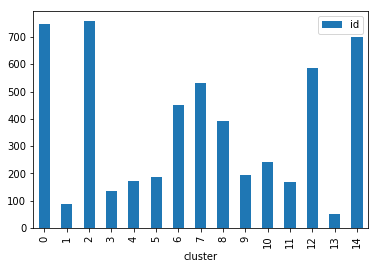

In [0]:
labels = kmeans.labels_
print(kmeans.labels_)

bugs = { 'id': df.loc[:,'id'], 'cluster': clusters }
frame = pd.DataFrame(bugs)
temp = frame.loc[:,['id','cluster']].groupby('cluster').count().plot.bar()
plt.show()

# Visualize the Results

This section uses several methods to visualize the results of the LDA.

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

In [0]:
# Creating and fitting the tsne model to the document embeddings
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(np.array(X))


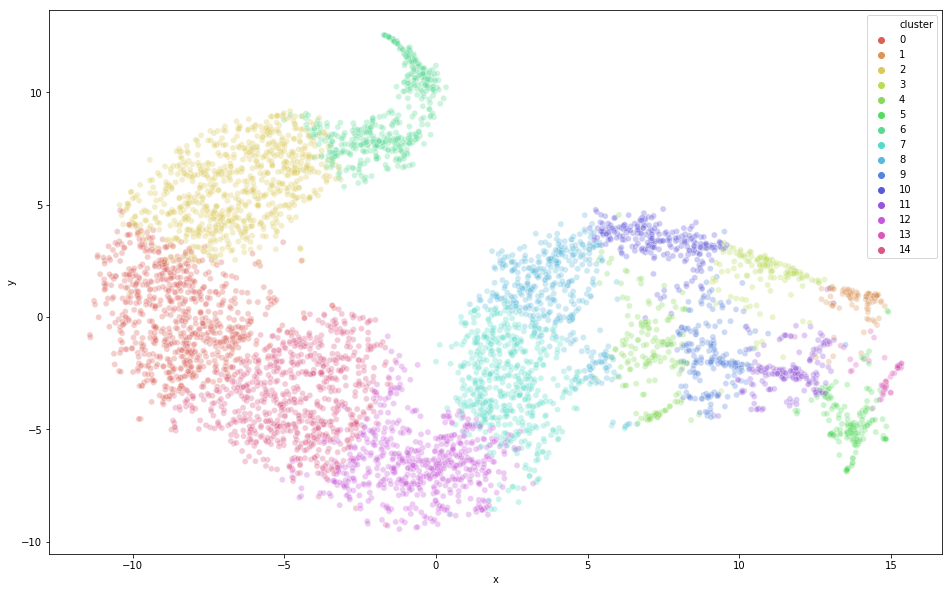

In [0]:
import seaborn as sns
df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x',
    y='y',
    hue="cluster",
    palette=sns.color_palette("hls", 15),
    legend="full",
    alpha=0.3,
    data=df
)

In [0]:
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=3,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(np.array(X))


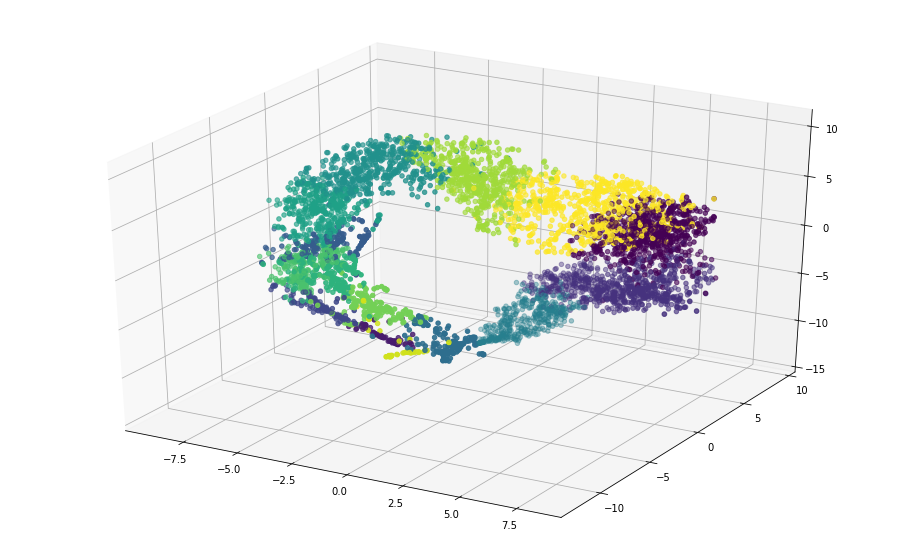

In [0]:
from mpl_toolkits.mplot3d import Axes3D

df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
df['z'] = tsne_d2v[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,"x"], 
    ys=df.loc[:,"y"], 
    zs=df.loc[:,"z"], 
    c=df.loc[:,"cluster"], 
)
plt.show()

In [0]:
from sklearn.decomposition import PCA

pca_20 = PCA(n_components=20)
pca_result_20 = pca_20.fit_transform(X)

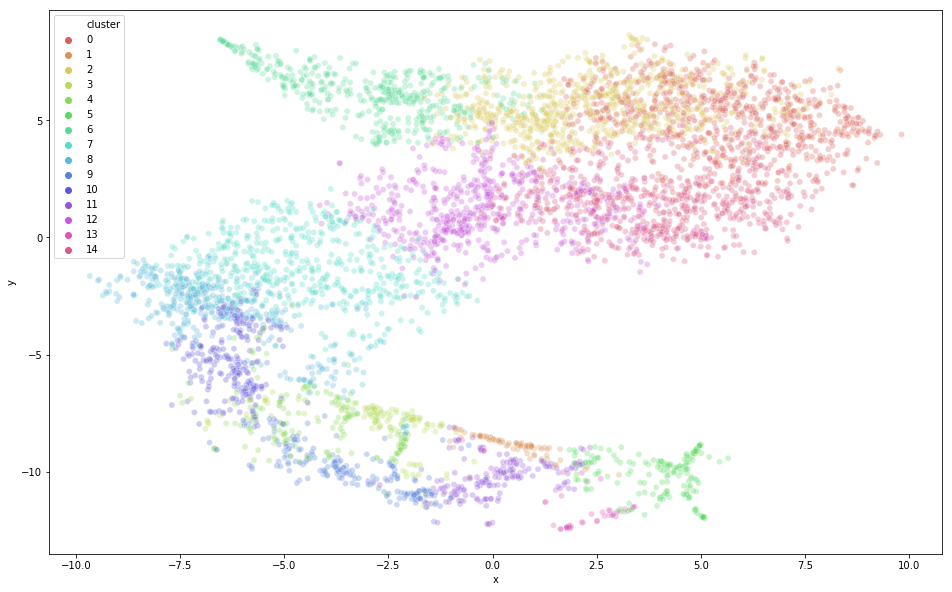

In [0]:
tsne_d2v = tsne_model.fit_transform(np.array(pca_result_20))
df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x',
    y='y',
    hue="cluster",
    palette=sns.color_palette("hls", 15),
    legend="full",
    alpha=0.3,
    data=df
)